## An SPM example using CMA-ES

This notebook introduces a synthetic parameterisation of the single-particle model using the covariance matrix adaptation evolution strategy (CMA-ES). To start, we install the develop branch of PyBOP,

In [1]:
%pip install --upgrade pip ipywidgets
%pip install git+https://github.com/pybop-team/PyBOP.git@develop -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.7/423.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 15.8 MB/

Next, we import the added packages plus any additional dependencies,

In [21]:
import pybop
import numpy as np

## Generate Synthetic Data

We need to generate the synthetic data required for later parameterisation. To do this we will run the PyBOP forward model and store the generated data. First, we need to define the parameter set, and the corresponding forward model,

In [ ]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)

Next, we simulate the forward model with the default constant current, which is defined in the parameter set. This can be viewed and modified as,

In [ ]:
parameter_set["Current function [A]"]

Now, we generate the fitting data via the model.predict() method. Additionally, we corrupt the synthetic voltage vector with gaussian noise to increase the fitting problem's difficulty.

In [22]:
sigma = 0.001
t_eval = np.arange(0, 900, 2)
values = model.predict(t_eval=t_eval)
corrupt_values = values["Terminal voltage [V]"].data + np.random.normal(
    0, sigma, len(t_eval)
)

## Identify the Parameters

Now, to blind fit the synthetic parameters we need to define the observation variables. For the observed voltage variable, we used the newly corrupted voltage array,

In [64]:
# Form dataset for optimisation
dataset = [
    pybop.Dataset("Time [s]", t_eval),
    pybop.Dataset("Current function [A]", values["Current [A]"].data),
    pybop.Dataset("Terminal voltage [V]", corrupt_values),
]

Next, we define the targeted forward model parameters for estimation. Furthermore, PyBOP provides functionality to define a prior for the parameters. The initial values used in the estimiation will be randomly drawn from the prior distribution. The bounds provide constraints for the optimisers that have bound functionality.

In [65]:
# Fitting parameters
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.7, 0.05),
        bounds=[0.6, 0.9],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.58, 0.05),
        bounds=[0.5, 0.8],
    ),
]

We can now define the problem class, the cost function, and the optimisation class. For this example, we limit the maximum number of iterations, however this is optional.

In [66]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)
optim = pybop.Optimisation(cost, optimiser=pybop.CMAES)
optim.set_max_iterations(100)

Finally, we run the estimation algorithm.

In [68]:
x, final_cost = optim.run()

Let's view the identified parameters:

In [69]:
x

array([0.48367449, 0.63380314])

## Plotting

PyBOP offers multiple plotting methods to view the optimisation results. First, we will use the quick_plot method to show the fitting system response to the target, 

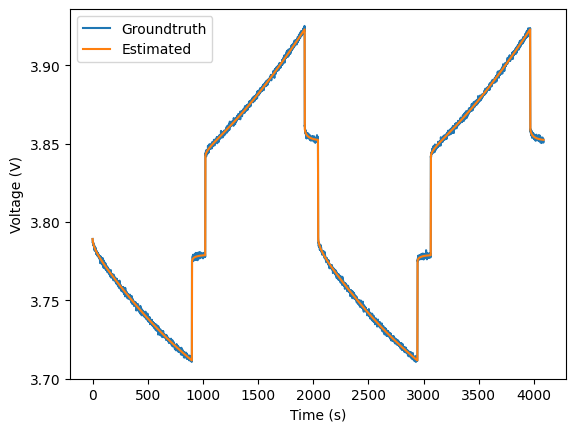

In [71]:
pybop.quick_plot(x, cost, title="Optimised Comparison")

Next, we can query the convergence of the cost function during the optimisation process as,

In [71]:
pybop.plot_convergence(optim)

The corresponding parameter values that form the above cost values can be plotted as well,

In [ ]:
pybop.plot_parameters(optim)

Finally, we can query the cost function across a two-dimensional space and plot the cost landscape as a contour, 

In [ ]:
# Plot the cost landscape
pybop.plot_cost2d(cost, steps=15)

We offer functionality to overlay the optimisation trace on the cost landscape, as well as modifying the two-dimensional range. The 'red X' indicates the initialisation values.

In [ ]:
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.6, 0.9], [0.5, 0.8]])
pybop.plot_cost2d(cost, optim=optim, bounds=bounds, steps=15)